# Importing Dependencies

In [0]:
# Basic
import numpy as np
import pandas as pd
import json
import os

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# data prep
from sklearn.model_selection import train_test_split

# Modeling
from sklearn.linear_model import LogisticRegression  
from sklearn.preprocessing import StandardScaler  

# Model accuracy reporting
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

# Importing files

Training data can either be downloaded manually at https://www.kaggle.com/c/ieee-fraud-detection/data or downlaoded automatically using kaggle api credentials. Instructions for how to download your kaggle credentials as a json: https://github.com/Kaggle/kaggle-api#api-credentials

### Download files automatically using api credentials stored in kaggle.json

In [0]:
# retrieve credentials from file
with open('kaggle.json') as f:
    d = json.load(f)
    
# Use credentials to download data
os.environ['KAGGLE_USERNAME'] = d["username"]
os.environ['KAGGLE_KEY'] = d["key"]
! kaggle competitions download -c ieee-fraud-detection

# unzip all data files
!unzip train_transaction.csv.zip
!unzip train_identity.csv.zip
!unzip test_transaction.csv.zip
!unzip test_identity.csv.zip

# remove unuzed zip files
os.remove("train_transaction.csv.zip")
os.remove("train_identity.csv.zip")
os.remove("test_transaction.csv.zip")
os.remove("test_identity.csv.zip")

# Data preprocessing

In [0]:
# store CSV files in memory
train_transaction = pd.read_csv('train_transaction.csv')
test_transaction = pd.read_csv('test_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')
test_identity = pd.read_csv('test_identity.csv')

# merge ID and transaction information by their TransactionID fields
train_df = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test_df = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [18]:
print("train: ",train_df.shape)
print("test:  ", test_df.shape)

train:  (590540, 434)
test:   (506691, 433)


# Visualize N/A values

Y axis is % of N/A values in all of datatype

X axis is variable names

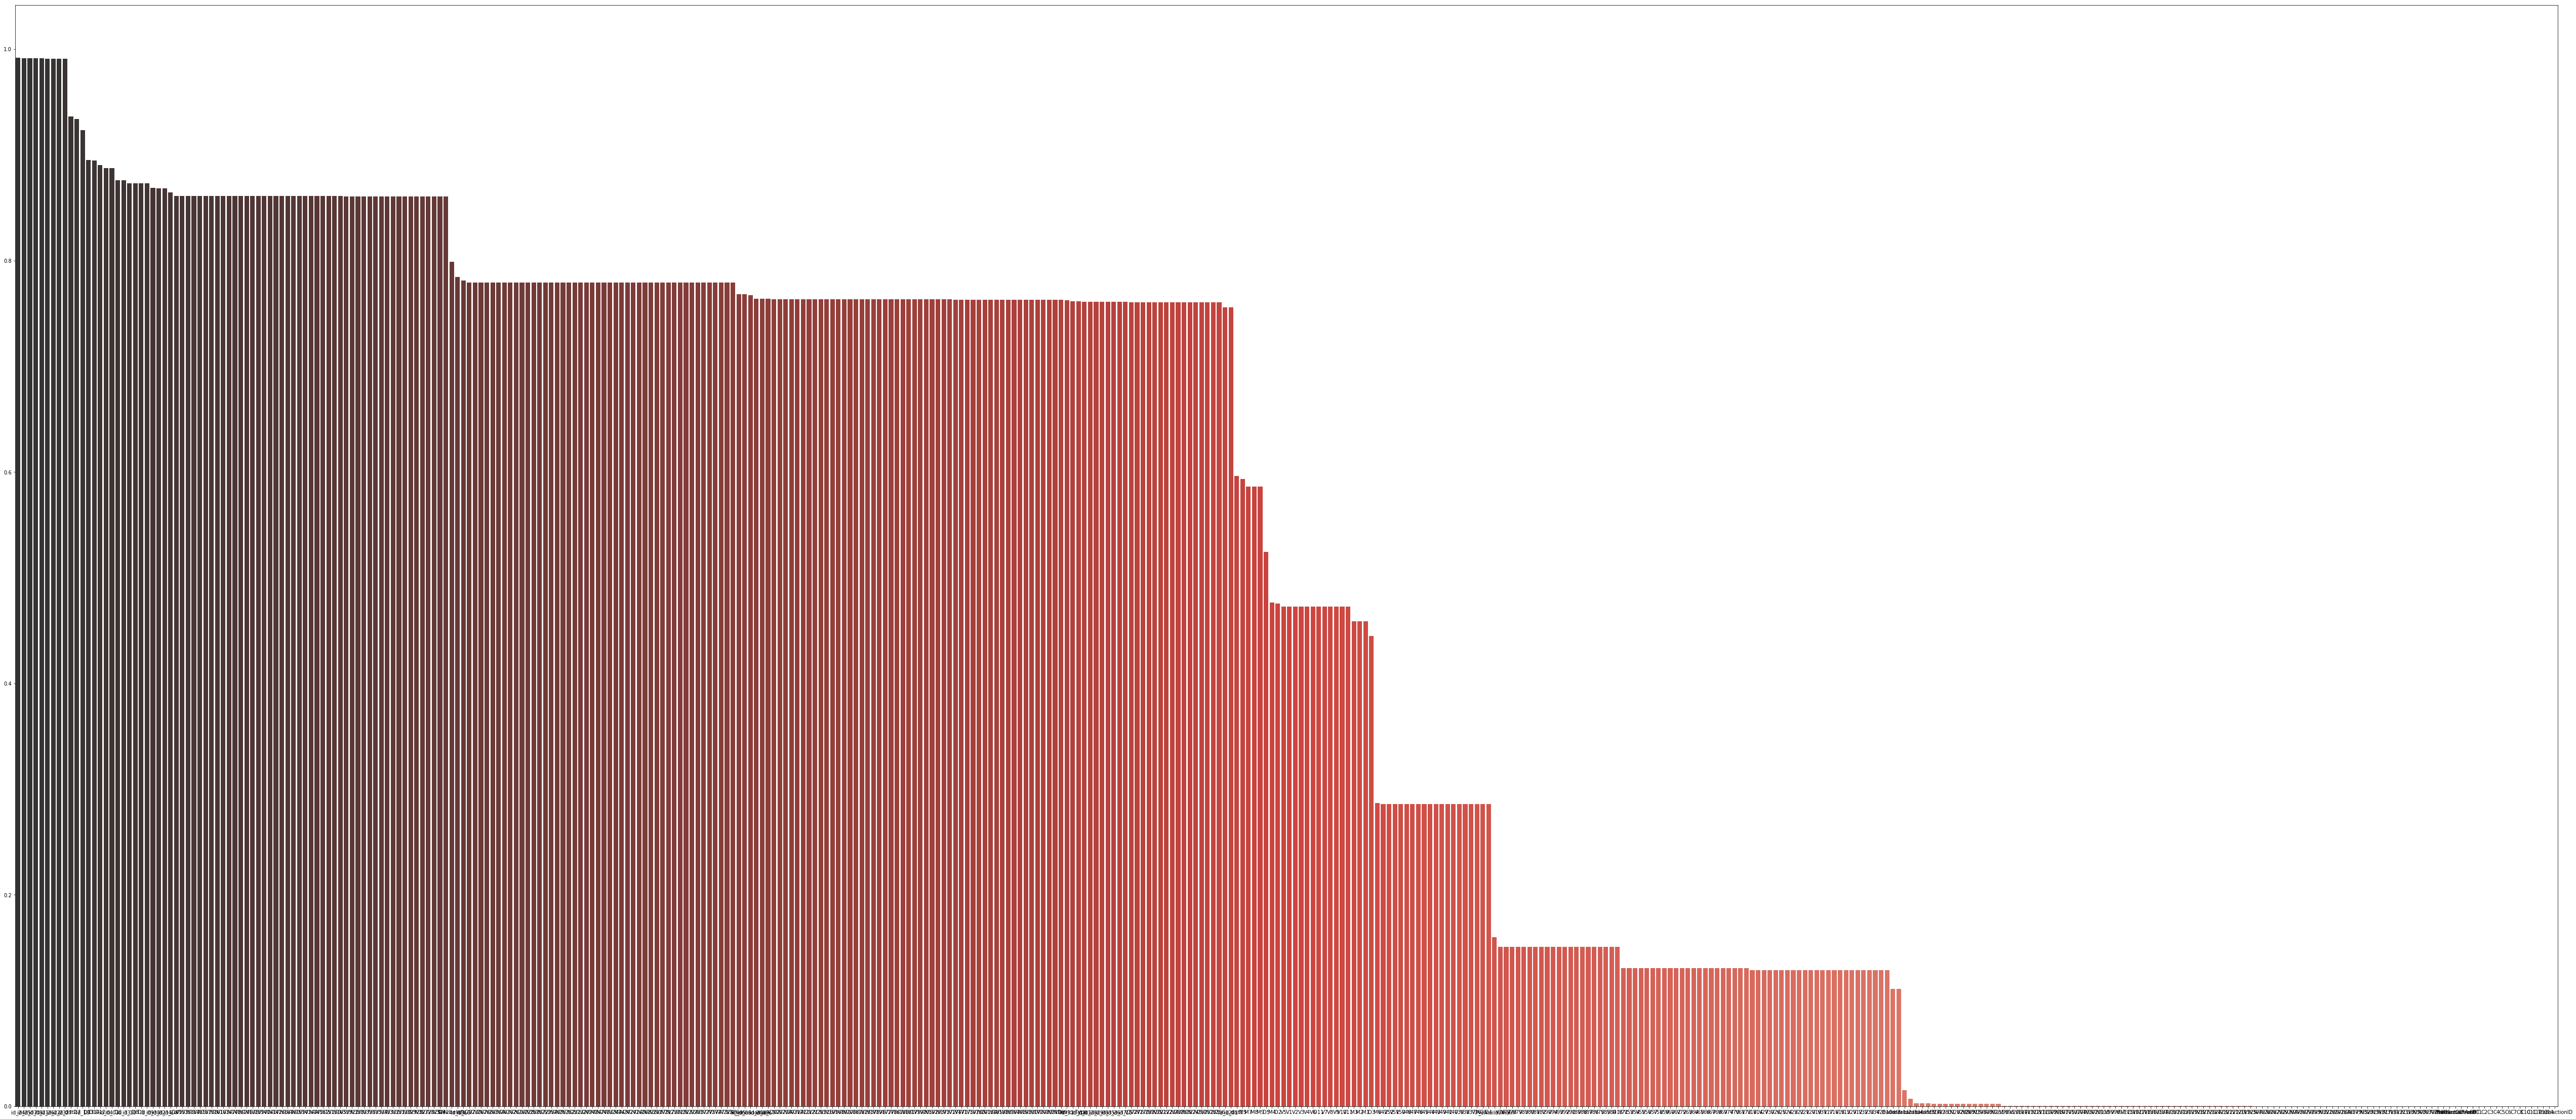

In [27]:
# define chart size, size is large enough to read X labels
plt.figure(figsize=(90,40))

# create barplot
sns.barplot(y=train_df.isnull().sum().sort_values(ascending=False)/len(train_df),
            x=train_df.isnull().sum().sort_values(ascending=False).index,
            palette="Reds_d")

## Handling N/A values

In [0]:
# create list of N/A counter per field
columns_def = pd.DataFrame({"na_count":train_df.isnull().sum().sort_values(ascending=False)})


# Append additional column containing percentage of N/A data
columns_def["per"]=columns_def["na_count"]/len(train_df)

### Investigating what data has too many N/As to be useful

In [37]:
#cycle throungh various limit for percent Na per column
range=[0.05, 0.10 ,0.15, 0.25, 0.40, 0.60, 0.75]
for i in range: 
    print (columns_def[columns_def["per"]<i].shape[0]/train_df.shape[1])

0.25806451612903225
0.25806451612903225
0.3686635944700461
0.41935483870967744
0.46543778801843316
0.5207373271889401
0.5207373271889401


I'm willing to accept training on 36% of data that is left, so I will use 15% as N/A limit


In [0]:
# Only columns with less than 15% N/A values will remain
limit=0.15

# Select final columns based on N/A percentage limit
columns_final = columns_def[columns_def["per"]<limit].index 

# Only keep columns in columns_final
train_df = train_df[train_df.columns.intersection(columns_final)]

## Handling Catagorial variables


In [42]:
#Show categorical variables
train_df[train_df.select_dtypes(include=['object']).columns]

,ProductCD,card4,card6
0,W,discover,credit
1,W,mastercard,credit
2,W,visa,debit
3,W,mastercard,debit
4,H,mastercard,credit
5,W,visa,debit
6,W,visa,debit
7,W,visa,debit
8,H,visa,debit
9,W,mastercard,debit


In [44]:
# Turn catagory variables into collumbs with boolean values
card6_dummy_df=pd.get_dummies(train_df["card6"])

# Put new data back in train_df
train_df=pd.concat([train_df,card6_dummy_df],axis=1)

# Drop catagory variables
train_df=train_df._get_numeric_data()

# Drop all rows with any N/A values
train_df=train_df.dropna()

# See what percentage of fraud labels remain
len(train_df[train_df["isFraud"]==1])/len(train_df)*100

2.04579077462003

## Prepair X and Y data for models


In [0]:
# X data
x_df = train_df.drop(["isFraud"],axis=1)

# Y data
y_df = train_df["isFraud"]

# Divide split data into training data and test data
# 50% test 50% train
X_train,X_test,y_train,y_test = train_test_split(x_df,y_df,test_size=0.50)

# Modeling


In [0]:
# define model
lRModel = LogisticRegression(solver='lbfgs')  

# train model on training data
lRModel.fit(X_train, y_train)

In [0]:
# make predicitons on test data
y_pred=lRModel.predict(X_test)

In [58]:
# overall accuracy score
accuracy_score(y_test, y_pred)

0.9795993030562173

In [59]:
# score on fraud detections
recall_score(y_test, y_pred)

0.005452067242162653